In [1]:
#Set up environment and import necessary dependencies

%matplotlib inline
from __future__ import division;
from __future__ import print_function;
from __future__ import absolute_import;
import sys, os;
from collections import OrderedDict, namedtuple, Counter;
import numpy as np;
import theano
np.random.seed(1234)

scriptsDir = os.environ.get("KERAS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable KERAS_DIR");
sys.path.insert(0,scriptsDir)
import keras

scriptsDir = os.environ.get("DEEPLIFT_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable DEEPLIFT_DIR");
sys.path.insert(0,scriptsDir)

#Import some general util stuff
scriptsDir = os.environ.get("UTIL_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable UTIL_SCRIPTS_DIR to point to av_scripts");
sys.path.insert(0,scriptsDir);
import pathSetter;
import util;
import fileProcessing as fp
from plottingUtilitiesPackage import matplotlibHelpers as mplh;

scriptsDir = os.environ.get("ENHANCER_SCRIPTS_DIR");
if (scriptsDir is None):
    raise Exception("Please set environment variable ENHANCER_SCRIPTS_DIR to point to enhancer_prediction_code");
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/");
import criticalSubsetIdentification as csi
#import deepLIFT stuff
import deepLIFTutils
sys.path.insert(0,scriptsDir+"/featureSelector/deepLIFFT/kerasBasedBackprop");
from deepLIFTonGPU import ScoreTypes, Activations_enum, OutLayerInfo, getScoreFunc

Using gpu device 0: GeForce GT 750M (CNMeM is disabled, CuDNN not available)
/Users/avantishrikumar/anaconda/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:5: UserWarning: downsample module has been moved to the pool module.
  warnings.warn("downsample module has been moved to the pool module.")
Using Theano backend.


In [2]:
#Load the keras model, make sure you normalise the weights
#of the first convolutional layer to be mean-centered at each position.
import vgg16_keras 
reload(vgg16_keras)
from vgg16_keras import *
import h5py
reload(deepLIFTutils)
#/srv/scratch/annashch/cs231n_project/vgg16_weights_dropout_regularization_augmenteddataTintContrast.stupidsgd.hdf5
keras_model=VGG_16('vgg16_weights_dropout_regularization_augmenteddataTintContrast.stupidsgd.hdf5')
#mean_normalise_softmax_weights(keras_model.layers[-2])


In [3]:
import keras_conversion as kc
reload(kc)
import deeplift_backend as B
reload(B)
import blobs
reload(blobs)
import models
reload(models)
import deeplift_util
reload(deeplift_util)
deeplift_model = kc.convert_sequential_model(keras_model)

Mean-normalising softmax


In [4]:
import h5py
data=h5py.File('imagenet.validation.first50.hdf5','r')
validData=np.asarray(data['X_valid'])
Y_valid=np.asarray(data['Y_valid'])
data=validData 

In [ ]:
#get the outputs of the net on the validation set
#reload(deepLIFTutils)
#print(np.shape(data))
#import theano
#import deeplift_util
#
#keras_output_func = theano.function([keras_model.layers[0].input],
#                                     keras_model.layers[-1].get_output(train=False),
#                                     allow_input_downcast=True)
#keras_outputs = deeplift_util.run_function_in_batches(keras_output_func, input_data_list=[data])
#keras_outputs=np.array(keras_outputs)

In [ ]:
#deeplift_output_func = theano.function([deeplift_model.get_layers()[0].get_activation_vars()],
#                                        deeplift_model.get_layers()[-1].get_activation_vars(),
#                                        allow_input_downcast=True)
#deeplift_outputs = deeplift_util.run_function_in_batches(deeplift_output_func, input_data_list=[data])
#deeplift_outputs = np.array(deeplift_outputs)

In [ ]:
#np.sum(np.abs(keras_outputs-deeplift_outputs))

In [13]:
#compile the gradient function
index_var = theano.shared(0)
grad_var = theano.tensor.grad(
            theano.tensor.sum(deeplift_model.get_layers()[-2].get_activation_vars()[:,index_var]),
            deeplift_model.get_layers()[0].get_activation_vars())
grad_func = theano.function([deeplift_model.get_layers()[0].get_activation_vars()], grad_var, allow_input_downcast=True)

In [15]:
target_contribs_func = deeplift_model.get_target_contribs_func(input_layer_idx=0)

In [55]:
#idx = 18 #car
#idx = 0 #kart
idx = 5 #bear


class: 144


In [56]:
#compute the gradients


Done 0


Done 0


In [58]:
def rescale_func(values):
    min_val = 70.0
    values = (255.0 - min_val)*(values - np.min(values))/(np.max(values)-np.min(values))  + min_val
    return values

class: 117
Done 0
Done 0
class: 144
Done 0
Done 0
class: 15
Done 0
Done 0


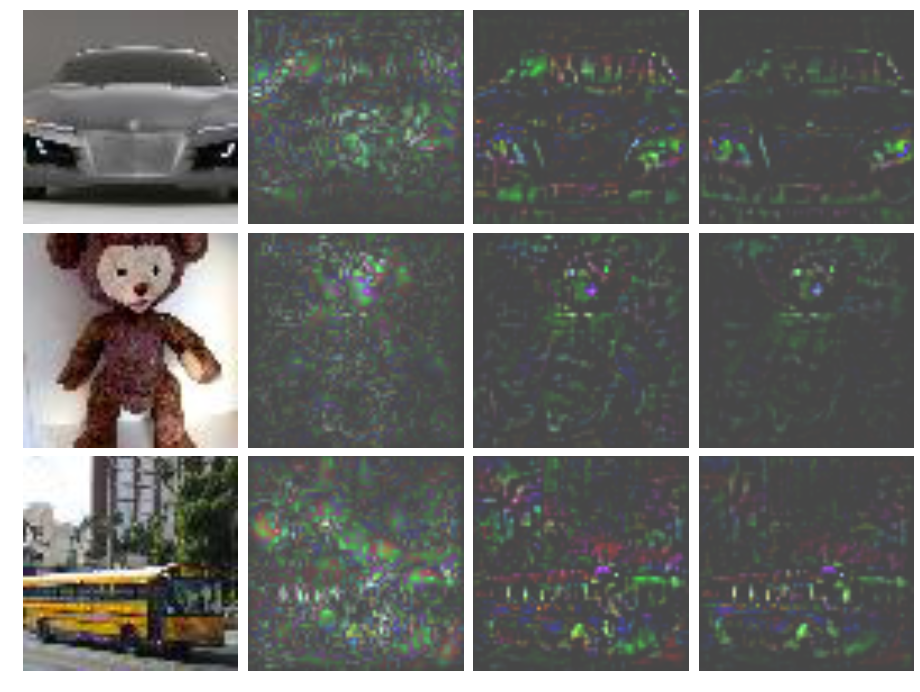

In [83]:
import skimage 
from skimage.io import imread
import matplotlib.pyplot as plt

indices = [18, 5, 8]
fig = plt.figure(figsize=(20, 4*len(indices)), facecolor='w')
for i,idx in enumerate(indices):
    softmax_class = np.argmax(Y_valid[idx])
    print("class:",softmax_class)
    #compute gradients
    index_var.set_value(softmax_class)
    gradients = deeplift_util.run_function_in_batches(grad_func, input_data_list=[[data[idx]]])
    #compute deeplift
    deeplift_contribs = target_contribs_func(task_idx=softmax_class,
                                             input_data_list=[[data[idx]]],
                                             batch_size=10,
                                             progress_update=10000)

    img_original=imread('val_'+str(idx)+'.JPEG').astype(np.uint8)
    fig.subplots_adjust(wspace=0.05)
    fig.subplots_adjust(hspace=0)
    #fig.subplots_adjust(right=0)
    plt.suptitle("")
    plt.subplot(len(indices), 5, i*5 + 1)
    plt.axis('off')
    #plt.title('Original')
    plt.imshow(img_original)
    plt.subplot(len(indices),5, i*5 + 2)
    plt.axis('off')
    #plt.title('Preprocessed')
    #plt.imshow(data[idx].transpose(1,2,0).astype(np.uint8))
    #plt.subplot(1,5,3)
    #plt.title('Abs. Gradient')
    plt.imshow(rescale_func(np.abs(gradients[0])).transpose(1,2,0).astype(np.uint8))
    plt.subplot(len(indices),5, i*5 + 3)
    plt.axis('off')
    #plt.title('Pos. grad*inp (Taylor)')
    plt.imshow(rescale_func(gradients[0]*data[idx]*((gradients[0]*data[idx]) > 0)).transpose(1,2,0).astype(np.uint8))
    plt.subplot(len(indices),5, i*5 + 4)
    plt.axis('off')
    #plt.title('Pos. LIFTPAD')
    plt.imshow(rescale_func(deeplift_contribs[0]*(deeplift_contribs[0]>0)).transpose(1,2,0).astype(np.uint8))
